In [1]:
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import pandas as pd
from torch.utils.data import DataLoader, Dataset, ConcatDataset
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 112
def readfile(path, label):
    # label 是一個 boolean variable，代表需不需要回傳 y 值
    image_dir = sorted(os.listdir(path))
    x = np.zeros((len(image_dir), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.uint8)
    y = np.zeros((len(image_dir)), dtype=np.uint8)
    for i, file in enumerate(image_dir):
        img = cv2.imread(os.path.join(path, file))
        # resize to IMAGE_SIZE x ? or ? x IMAGE_SIZE
        height = img.shape[0]
        width = img.shape[1]
        rate = IMAGE_SIZE / max(height, width)
        height = int(height * rate)
        width = int(width * rate)
        img = cv2.resize(img, (width, height))
        # pad black
        # from https://blog.csdn.net/qq_20622615/article/details/80929746
        W, H = IMAGE_SIZE, IMAGE_SIZE
        top = (H - height) // 2
        bottom = (H - height) // 2
        if top + bottom + height < H:
            bottom += 1
        left = (W - width) // 2
        right = (W - width) // 2
        if left + right + width < W:
            right += 1
        img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=(0, 0, 0))
        # to np array
        x[i, :, :] = img
        if label:
          y[i] = int(file.split("_")[0])
    if label:
      return x, y
    else:
      return x

In [3]:
workspace_dir = './food-11'
print("Reading data")
valid_x, valid_y = readfile(os.path.join(workspace_dir, "validation"), True)
print("Size of Validation data = {}".format(len(valid_x)))

Reading data
Size of Validation data = 3430


In [4]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        # input 維度 [3, IMAGE_SIZE, IMAGE_SIZE]
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            
            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
        )
        self.fc = nn.Sequential(
            nn.Linear(7*7*512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            
            nn.Linear(1024, 11)
        )

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)

In [5]:
class ImgDataset(Dataset):
    def __init__(self, x, y=None, transform=None):
        self.x = x
        # label is required to be a LongTensor
        self.y = y
        if y is not None:
            self.y = torch.LongTensor(y)
        self.transform = transform
    def __len__(self):
        return len(self.x)
    def __getitem__(self, index):
        X = self.x[index]
        if self.transform is not None:
            X = self.transform(X)
        if self.y is not None:
            Y = self.y[index]
            return X, Y
        else:
            return X
test_transform = transforms.Compose([
    transforms.ToPILImage(),                                    
    transforms.ToTensor(),
])

In [6]:
model_best = torch.load('model_confusion.torch')

test_set = ImgDataset(valid_x, transform=test_transform)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

model_best.eval()
prediction = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        test_pred = model_best(data.cuda())
        test_label = np.argmax(test_pred.cpu().data.numpy(), axis=1)
        for y in test_label:
            prediction.append(y)

C:\Users\mingc\anaconda3\envs\ML\lib\site-packages\torch\serialization.py:419: UserWarning: Couldn't retrieve source code for container of type Classifier. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "


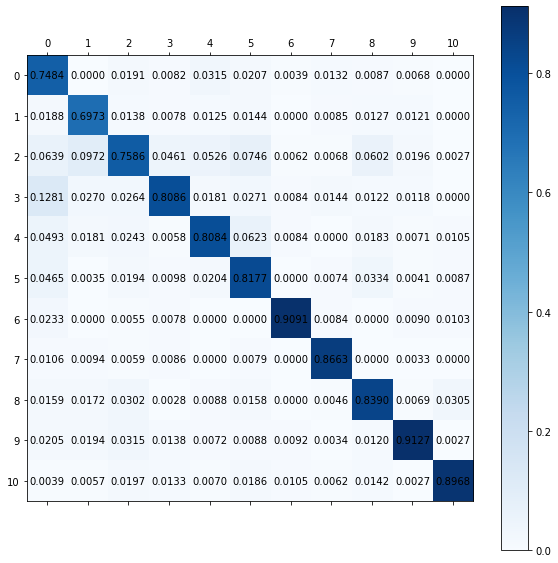

In [7]:
n = len(valid_y)

tmp = np.zeros((11, 11))
for i in range(n):
    tmp[prediction[i],valid_y[i]] += 1

mat = np.zeros((11,11))
for i in range(11):
    for j in range(11):
        if tmp[i][j] == 0:
            continue
        mat[i,j] = 2 * tmp[i,j] / (tmp.sum(1)[j] + tmp.sum(0)[i])

fig, ax = plt.subplots(figsize=(10,10))
cax = ax.matshow(mat, cmap=plt.get_cmap('Blues'))
fig.colorbar(cax)
ax.set_xticks(range(11))
ax.set_yticks(range(11))
for (i, j), z in np.ndenumerate(mat):
     ax.text(j, i, '{:0.4f}'.format(z), ha='center', va='center')
#     ax.text(j, i, '{:0.4f}'.format(z), ha='center', va='center',
#             bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
plt.savefig('confusion.pdf')